<a href="https://colab.research.google.com/github/chinmaykatdare05/Apple-Health-Analytics/blob/main/Apple%20Health%20Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Apple Health Analytics***

---

In [1]:
!pip install calplot --quiet

import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calplot
from statsmodels.tsa.seasonal import seasonal_decompose

## ***Load the XML File (export.xml)***

In [ ]:
tree = ET.parse('./export.xml')
root = tree.getroot()

df = pd.DataFrame([x.attrib for x in root.iter('Record')])

# Remove unnecessary columns
df.drop(columns=['sourceName', 'sourceVersion', 'creationDate', 'device'], inplace=True)

# Remove Rows containing Height and Weight info
df.drop(df.index[:2], inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,type,unit,startDate,endDate,value
0,HKQuantityTypeIdentifierStepCount,count,2022-06-28 13:35:04 +0530,2022-06-28 13:35:58 +0530,76
1,HKQuantityTypeIdentifierStepCount,count,2022-06-28 13:45:59 +0530,2022-06-28 13:53:38 +0530,652
2,HKQuantityTypeIdentifierStepCount,count,2022-06-28 18:39:08 +0530,2022-06-28 18:49:09 +0530,332
3,HKQuantityTypeIdentifierStepCount,count,2022-06-28 18:49:11 +0530,2022-06-28 18:57:16 +0530,155
4,HKQuantityTypeIdentifierStepCount,count,2022-06-28 19:13:52 +0530,2022-06-28 19:13:54 +0530,8


In [3]:
df.shape

(85116, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85116 entries, 0 to 85115
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   type       85116 non-null  object
 1   unit       84358 non-null  object
 2   startDate  85116 non-null  object
 3   endDate    85116 non-null  object
 4   value      85116 non-null  object
dtypes: object(5)
memory usage: 3.2+ MB


## ***Data Cleaning***

In [5]:
df['type'].value_counts()

type
HKQuantityTypeIdentifierBasalEnergyBurned                 21023
HKQuantityTypeIdentifierWalkingSpeed                      10477
HKQuantityTypeIdentifierWalkingStepLength                 10477
HKQuantityTypeIdentifierWalkingDoubleSupportPercentage     9374
HKQuantityTypeIdentifierActiveEnergyBurned                 8648
HKQuantityTypeIdentifierDistanceWalkingRunning             7813
HKQuantityTypeIdentifierStepCount                          7812
HKQuantityTypeIdentifierWalkingAsymmetryPercentage         7251
HKQuantityTypeIdentifierFlightsClimbed                     1439
HKCategoryTypeIdentifierSleepAnalysis                       758
HKQuantityTypeIdentifierAppleWalkingSteadiness               42
HKQuantityTypeIdentifierHeadphoneAudioExposure                1
HKDataTypeSleepDurationGoal                                   1
Name: count, dtype: int64

***Apple HealthKit quantity types:***

**BasalEnergyBurned**: Energy expended at rest.

**WalkingSpeed**: Walking speed of the user.

**WalkingStepLength**: Length of each step taken during walking.

**WalkingDoubleSupportPercentage**: Percentage of time during walking that both feet are on the ground.

**ActiveEnergyBurned**: Energy expended during physical activity.

**DistanceWalkingRunning**: Distance traveled by walking or running.

**StepCount**: Number of steps taken by the user.

**WalkingAsymmetryPercentage**: Asymmetry in steps taken during walking.

**SleepAnalysis**: Duration of sleep of the user.

**AppleWalkingSteadiness**: Measurement of walking steadiness based on walking activity.

In [6]:
# Shorten "Type" values
df['type'] = df['type'].str.replace('HKQuantityTypeIdentifier', '')
df['type'] = df['type'].str.replace('HKCategoryTypeIdentifier', '')
df['type'] = df['type'].str.replace('HKDataType', '')

# Remove unnecessary columns
df.drop(df[df['type'] == 'HeadphoneAudioExposure'].index, inplace=True)
df.drop(df[df['type'] == 'SleepDurationGoal'].index, inplace=True)
df.drop(df[df['type'] == 'FlightsClimbed'].index, inplace=True)

# Datetime Conversion
df['startDate'] = pd.to_datetime((df['startDate'].str)[:-6])
df['endDate'] = pd.to_datetime((df['endDate'].str)[:-6])

# Calculate 'duration'
df['duration'] = df['endDate'] - df['startDate']

# Drop 'endDate' column
df.drop('endDate', axis=1, inplace=True)

# Write units for each type
df_units = {
    'BasalEnergyBurned': 'kcal',
    'WalkingSpeed': 'km/hr',
    'WalkingStepLength': 'cm',
    'WalkingDoubleSupportPercentage': '%',
    'ActiveEnergyBurned': 'kcal',
    'DistanceWalkingRunning': 'km',
    'StepCount': 'count',
    'WalkingAsymmetryPercentage': '%',
    'SleepAnalysis': float('nan'),
    'AppleWalkingSteadiness': '%'
}

# Drop 'unit' column
df.drop('unit', axis=1, inplace=True)

# Reorder columns for clarity
df = df[['type', 'value', 'startDate', 'duration']]

# Convert 'value' to numeric, fill missing values with 1.0
df['value'] = pd.to_numeric(df['value'], errors='coerce').fillna(1.0)

df.tail()

,type,value,startDate,duration
85111,SleepAnalysis,1.0,2024-07-13 01:15:11,0 days 04:35:42
85112,SleepAnalysis,1.0,2024-07-14 00:08:20,0 days 09:57:48
85113,SleepAnalysis,1.0,2024-07-15 00:15:44,0 days 05:53:29
85114,SleepAnalysis,1.0,2024-07-15 23:00:00,0 days 07:18:44
85115,SleepAnalysis,1.0,2024-07-16 23:48:04,0 days 06:27:01


In [7]:
df.describe()

,value,startDate,duration
count,83675.000000,83675,83675
mean,46.089739,2023-11-01 14:11:22.634622208,0 days 00:17:59.509746041
min,0.000000,2023-03-03 08:37:37,0 days 00:00:01
25%,0.299000,2023-06-26 15:01:19.500000,0 days 00:00:30
50%,4.284000,2023-10-24 22:54:09,0 days 00:03:19
75%,53.180000,2024-03-11 07:54:22.500000,0 days 00:09:57
max,1188.000000,2024-07-17 18:51:47,7 days 00:00:00
std,135.937649,NaN,0 days 03:47:41.577786342


In [8]:
SleepAnalysis = df.loc[df['type'] == 'SleepAnalysis'].groupby(df['startDate'].dt.date)['duration'].sum()

# Pivot table to aggregate values by type and startDate.datea
data = df.pivot_table(index=df['startDate'].dt.date, columns='type', values='value', aggfunc='sum', fill_value=0)

data['SleepAnalysis'] = SleepAnalysis
data.tail()

type,ActiveEnergyBurned,AppleWalkingSteadiness,BasalEnergyBurned,DistanceWalkingRunning,SleepAnalysis,StepCount,WalkingAsymmetryPercentage,WalkingDoubleSupportPercentage,WalkingSpeed,WalkingStepLength
startDate,,,,,,,,,,
2024-07-13,47.961,0.0,1271.439,1.66859,0 days 05:02:35,3055,0.11,2.748,41.580,631
2024-07-14,47.775,0.0,1277.435,1.70682,0 days 09:57:48,2950,0.12,2.918,35.280,609
2024-07-15,224.047,0.0,1334.220,6.59308,0 days 13:12:13,11749,0.32,13.340,200.736,3274
2024-07-16,37.973,0.0,1276.529,1.32007,0 days 06:27:01,2534,0.01,1.933,29.484,463
2024-07-17,74.739,0.0,991.461,2.42476,NaT,4484,2.57,6.223,76.176,1348


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 2023-03-03 to 2024-07-17
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   ActiveEnergyBurned              503 non-null    float64        
 1   AppleWalkingSteadiness          503 non-null    float64        
 2   BasalEnergyBurned               503 non-null    float64        
 3   DistanceWalkingRunning          503 non-null    float64        
 4   SleepAnalysis                   389 non-null    timedelta64[ns]
 5   StepCount                       503 non-null    int64          
 6   WalkingAsymmetryPercentage      503 non-null    float64        
 7   WalkingDoubleSupportPercentage  503 non-null    float64        
 8   WalkingSpeed                    503 non-null    float64        
 9   WalkingStepLength               503 non-null    int64          
dtypes: float64(7), int64(2), timedelta64[ns](1)
memory 

In [10]:
data.describe()

type,ActiveEnergyBurned,AppleWalkingSteadiness,BasalEnergyBurned,DistanceWalkingRunning,SleepAnalysis,StepCount,WalkingAsymmetryPercentage,WalkingDoubleSupportPercentage,WalkingSpeed,WalkingStepLength
count,503.000000,503.000000,503.000000,503.000000,389,503.000000,503.000000,503.000000,503.000000,503.000000
mean,110.668064,0.063321,1392.813095,2.858825,0 days 07:08:02.516709511,4809.284294,0.663141,5.564095,75.812565,1267.880716
std,102.798422,0.210475,115.839888,2.265378,0 days 03:32:53.257219992,3765.497164,1.045184,4.559639,61.227381,1024.762560
min,0.000000,0.000000,907.985000,0.000000,0 days 00:01:19,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.596500,0.000000,1290.204000,1.003462,0 days 05:16:28,1767.000000,0.030000,1.865500,25.218000,438.500000
50%,87.485000,0.000000,1435.307000,2.524000,0 days 06:12:08,4232.000000,0.250000,4.901000,66.384000,1133.000000
75%,162.880500,0.000000,1480.253000,4.676745,0 days 10:40:49,7756.000000,0.870000,8.478000,118.350000,1982.500000
max,1086.101000,0.870036,1992.351000,15.281630,0 days 17:04:54,25109.000000,10.370000,25.128000,318.744000,5983.000000


## ***Exploratory Data Analysis***

### Basal Energy Burned

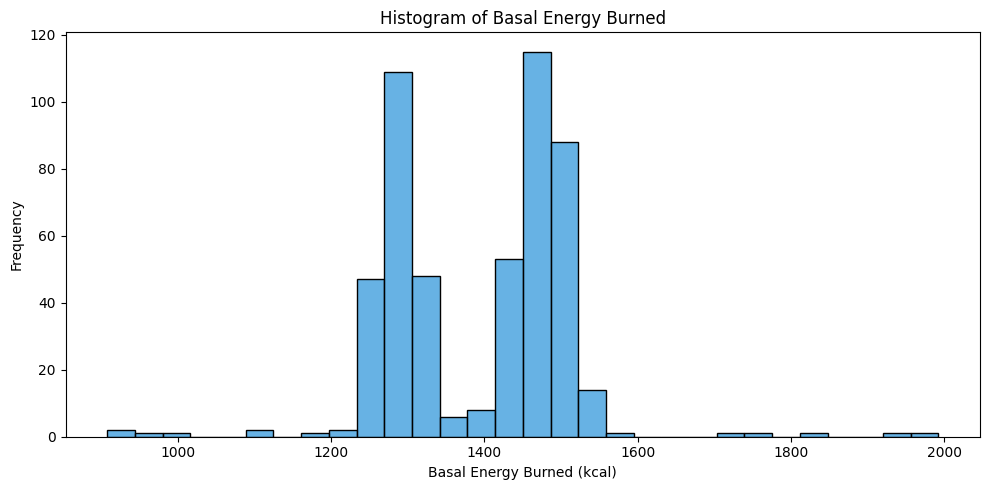

In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(data['BasalEnergyBurned'], bins=30, kde=False, color='#3498db')
plt.title('Histogram of Basal Energy Burned')
plt.xlabel('Basal Energy Burned (kcal)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Walking Speed

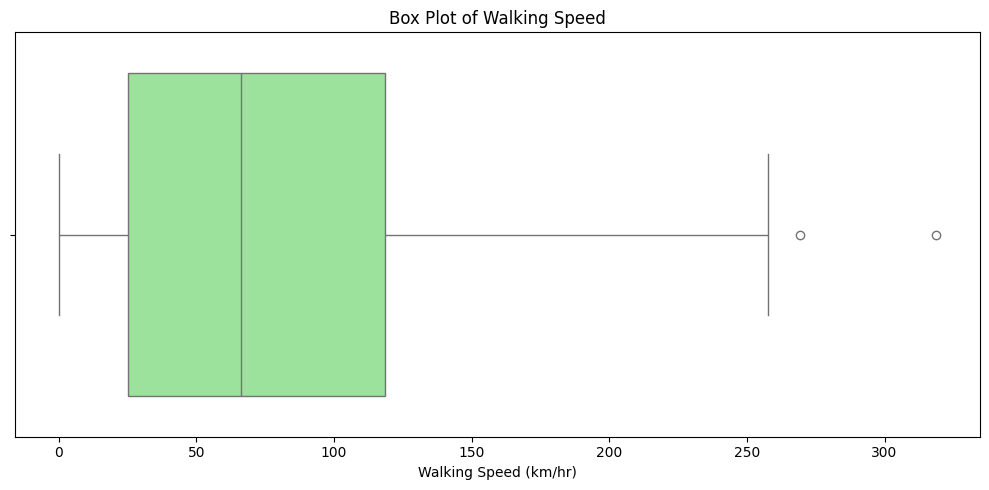

In [12]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['WalkingSpeed'], color='lightgreen')
plt.title('Box Plot of Walking Speed')
plt.xlabel('Walking Speed (km/hr)')
plt.tight_layout()
plt.show()

### Walking Speed vs. Distance Walking/Running

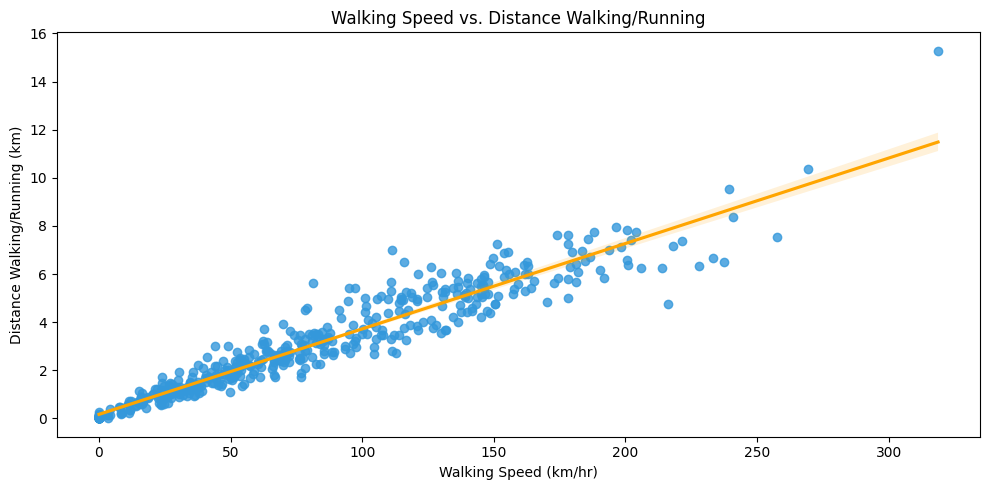

In [13]:
plt.figure(figsize=(10, 5))
sns.regplot(x='WalkingSpeed', y='DistanceWalkingRunning', data=data, scatter_kws={'color': '#3498db'}, line_kws={'color': 'orange'})
plt.title('Walking Speed vs. Distance Walking/Running')
plt.xlabel('Walking Speed (km/hr)')
plt.ylabel('Distance Walking/Running (km)')
plt.tight_layout()
plt.show()

### Correlation Heatmap

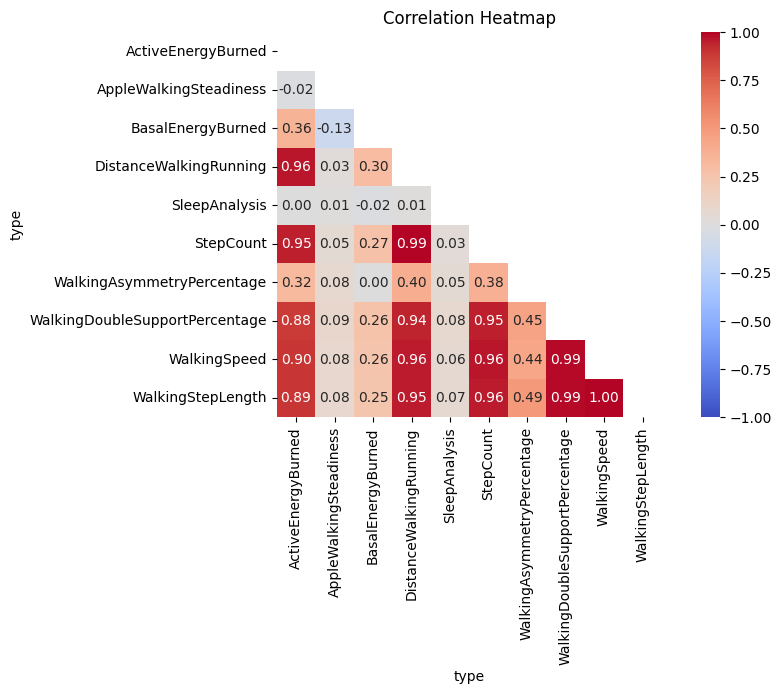

In [14]:
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(data.corr(), dtype=bool))
sns.heatmap(data.corr(), cmap='coolwarm', square=True,annot = True, fmt=".2f", mask = mask, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

### Pair Plot

<Figure size 2000x1000 with 0 Axes>

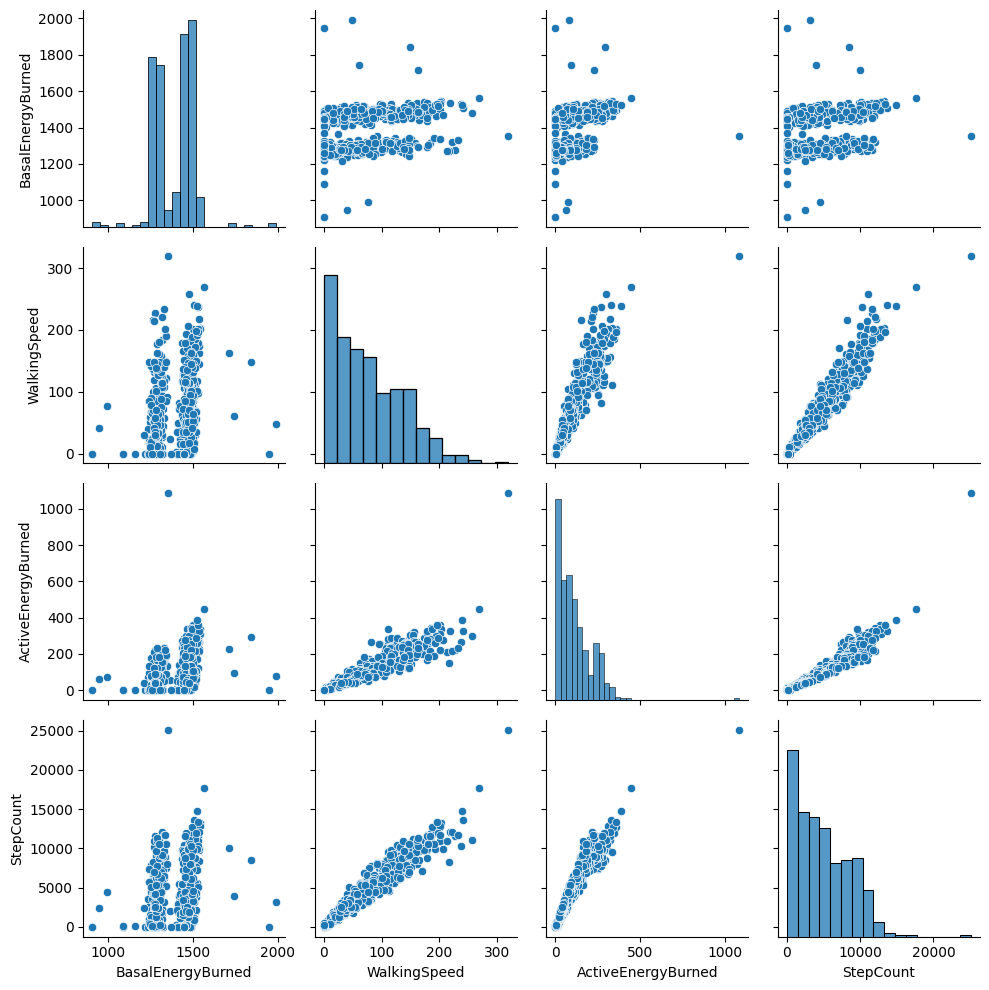

In [15]:
plt.figure(figsize=(20, 10))
sns.pairplot(data[['BasalEnergyBurned', 'WalkingSpeed', 'ActiveEnergyBurned', 'StepCount']])
plt.tight_layout()
plt.show()

### Step Count vs. Active Energy Burned

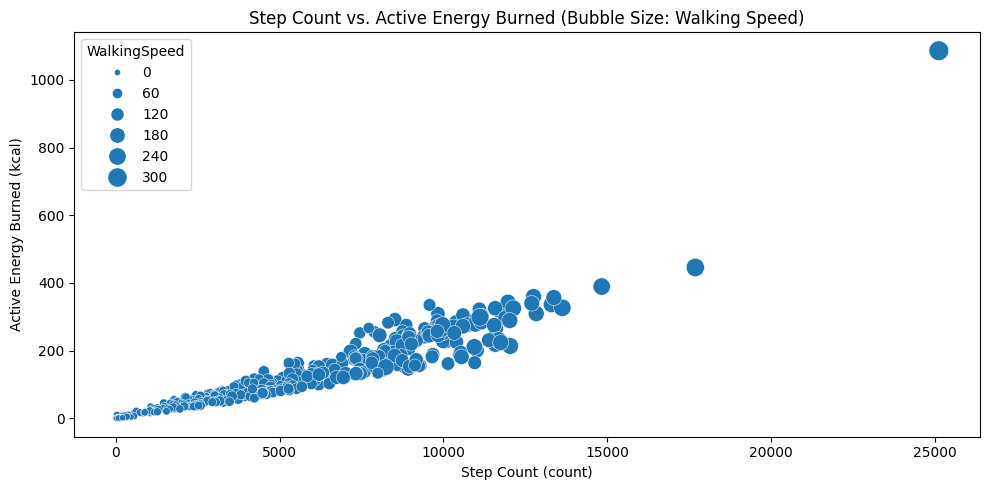

In [16]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='StepCount', y='ActiveEnergyBurned', size='WalkingSpeed', sizes=(20, 200), data=data)
plt.title('Step Count vs. Active Energy Burned (Bubble Size: Walking Speed)')
plt.xlabel('Step Count (count)')
plt.ylabel('Active Energy Burned (kcal)')
plt.tight_layout()
plt.show()

### Walking Step Length Distribution

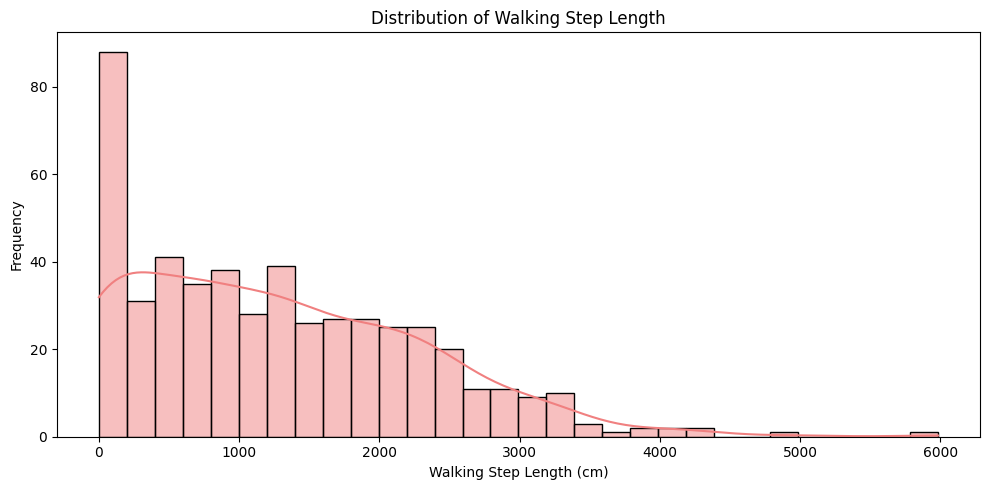

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(data['WalkingStepLength'], bins=30, kde=True, color='lightcoral')
plt.title('Distribution of Walking Step Length')
plt.xlabel('Walking Step Length (cm)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Distance Walking/Running

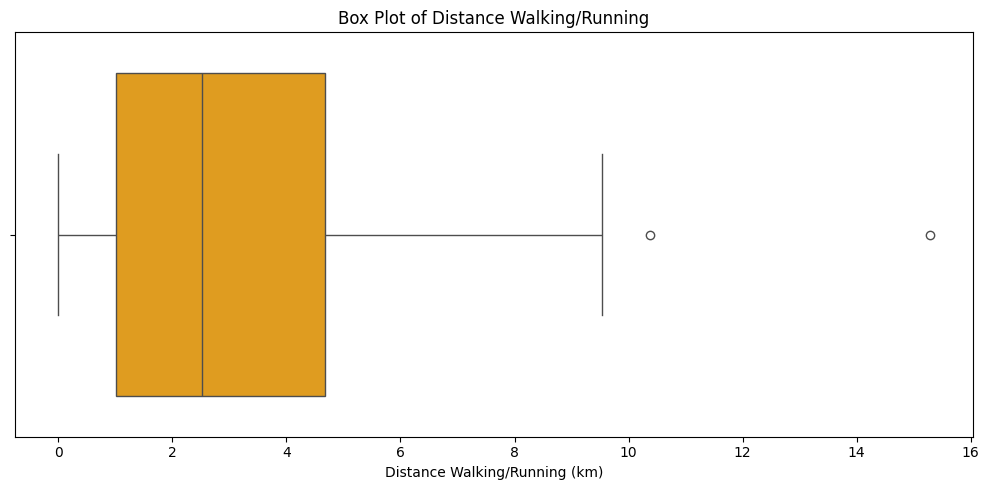

In [18]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['DistanceWalkingRunning'], color='orange')
plt.title('Box Plot of Distance Walking/Running')
plt.xlabel('Distance Walking/Running (km)')
plt.tight_layout()
plt.show()

### Walking Asymmetry Percentage

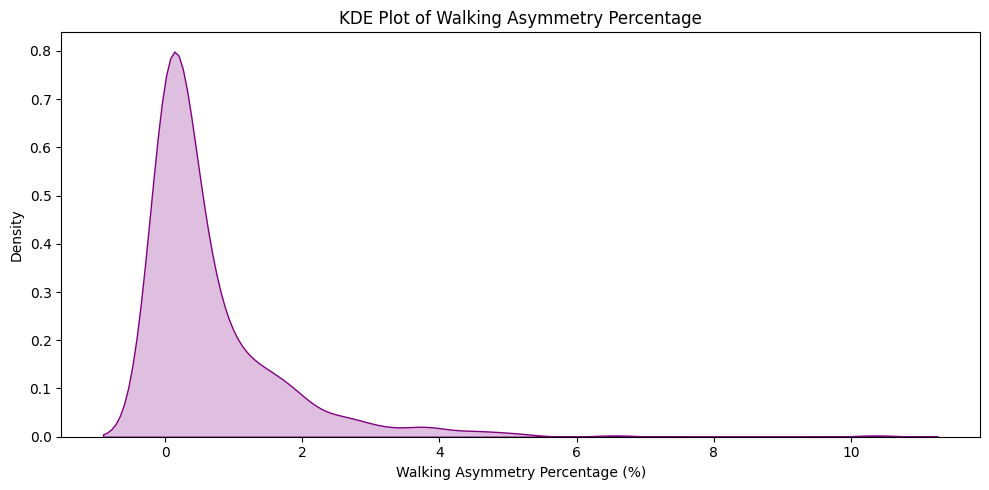

In [19]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data['WalkingAsymmetryPercentage'], fill=True, color='purple')
plt.title('KDE Plot of Walking Asymmetry Percentage')
plt.xlabel('Walking Asymmetry Percentage (%)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

Plot the following:
- Step Count (Group by day and week)
- Distance (Group by day and week)
- Active Energy Burned
- AppleWalkingSteadiness (Weekly)

## ***Advanced (Time Series) Data Exploration***

In [20]:
data.index = pd.to_datetime(data.index)
week_data = data.resample('W').sum()
month_data = data.resample('M').sum()

### Rolling Average of Active Energy Burned

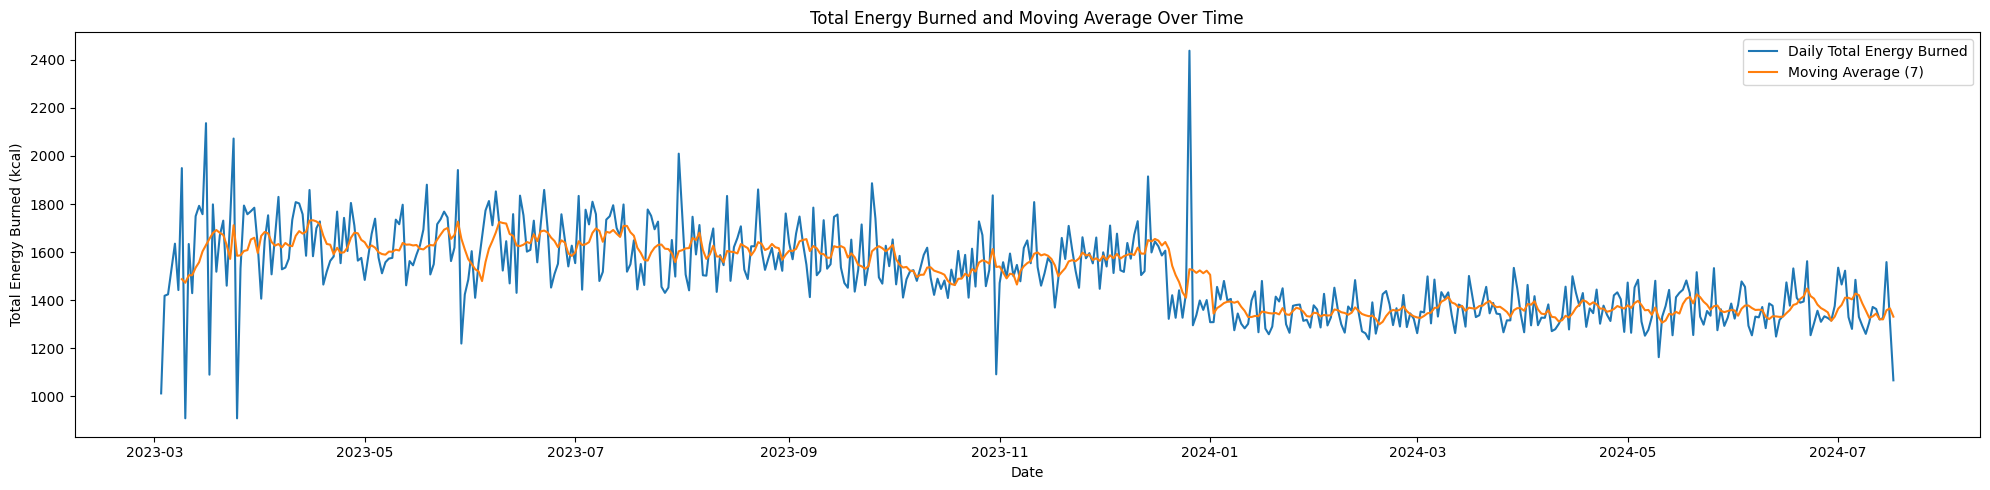

In [21]:
data['TotalEnergyBurned'] = data['BasalEnergyBurned'] + data['ActiveEnergyBurned']
data['RollingTotalEnergy'] = data['TotalEnergyBurned'].rolling(window=7).mean()

plt.figure(figsize=(20, 5))
sns.lineplot(x=data.index, y='TotalEnergyBurned', data=data, label='Daily Total Energy Burned')
sns.lineplot(x=data.index, y='RollingTotalEnergy', data=data, label='Moving Average (7)')
plt.title('Total Energy Burned and Moving Average Over Time')
plt.xlabel('Date')
plt.ylabel('Total Energy Burned (kcal)')
plt.legend()
plt.tight_layout()
plt.show()

### Monthly Aggregation of Distance Walking/Running

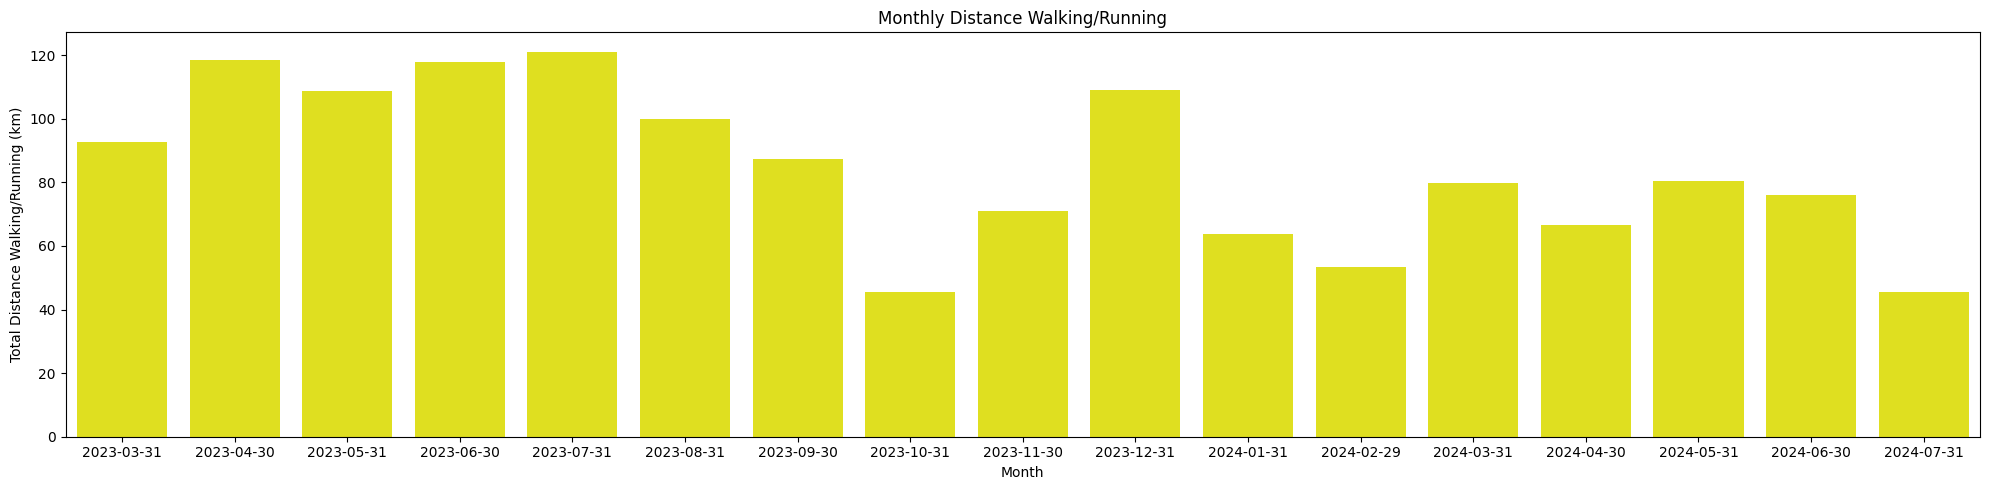

In [22]:
plt.figure(figsize=(20, 5))
sns.barplot(x=month_data.index, y='DistanceWalkingRunning', data=month_data, color='yellow')
plt.title('Monthly Distance Walking/Running')
plt.xlabel('Month')
plt.ylabel('Total Distance Walking/Running (km)')
plt.tight_layout()
plt.show()

### Time Series Plot of Walking Speed

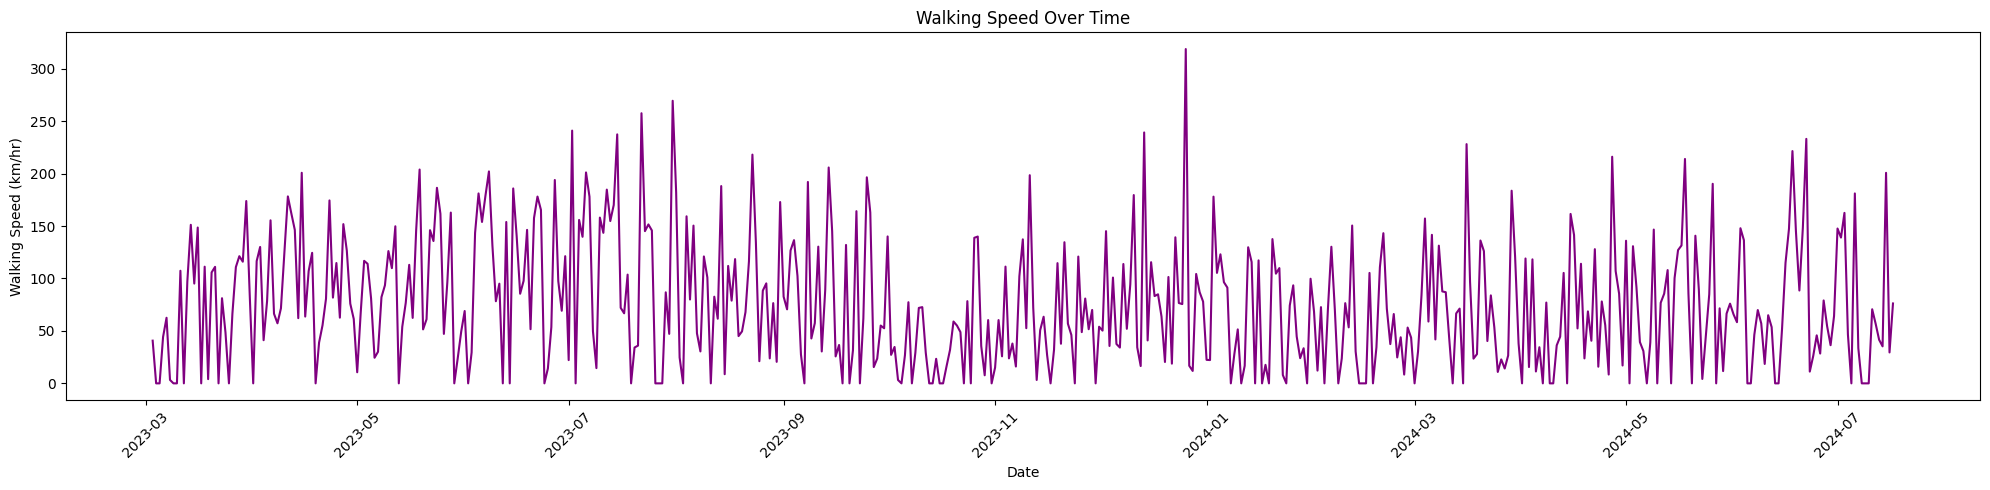

In [23]:
plt.figure(figsize=(20, 5))
sns.lineplot(x=data.index, y='WalkingSpeed', data=data, color='purple')
plt.title('Walking Speed Over Time')
plt.xlabel('Date')
plt.ylabel('Walking Speed (km/hr)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Seasonal Decomposition of Distance Walking/Running

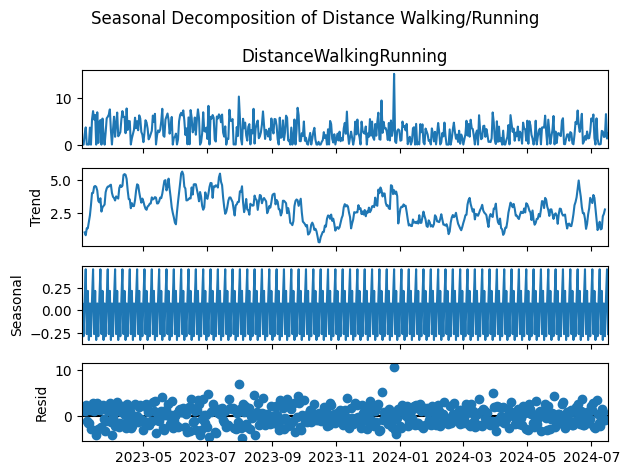

In [24]:
seasonal_decompose(data['DistanceWalkingRunning'], model='additive').plot()
plt.suptitle('Seasonal Decomposition of Distance Walking/Running')
plt.tight_layout()
plt.show()

### Distribution of Sleep Analysis Duration

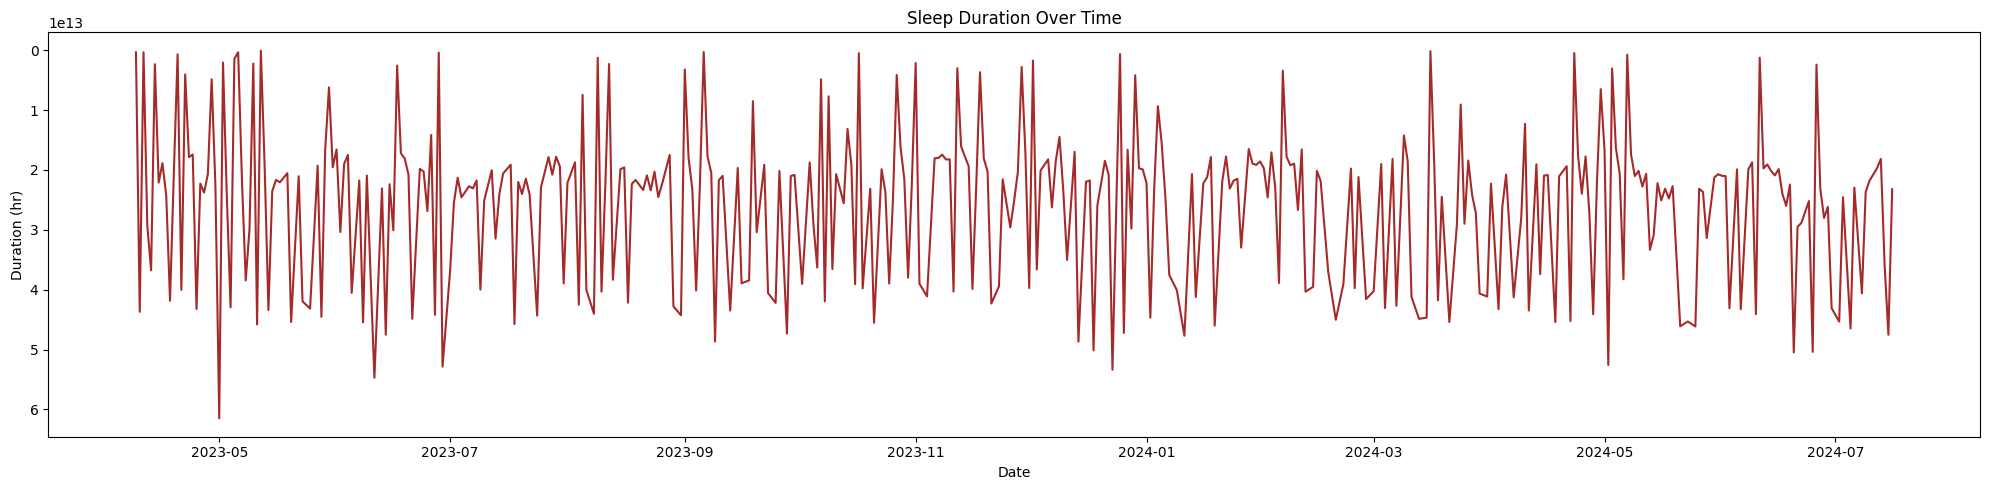

In [25]:
plt.figure(figsize=(20, 5))
sns.lineplot(x=data.index, y='SleepAnalysis', data=data, color='brown')
plt.title('Sleep Duration Over Time')
plt.xlabel('Date')
plt.ylabel('Duration (hr)')
plt.tight_layout()
plt.show()

### Step Count Distribution

(<Figure size 2000x500 with 3 Axes>,
 array([<Axes: ylabel='2023'>, <Axes: ylabel='2024'>], dtype=object))

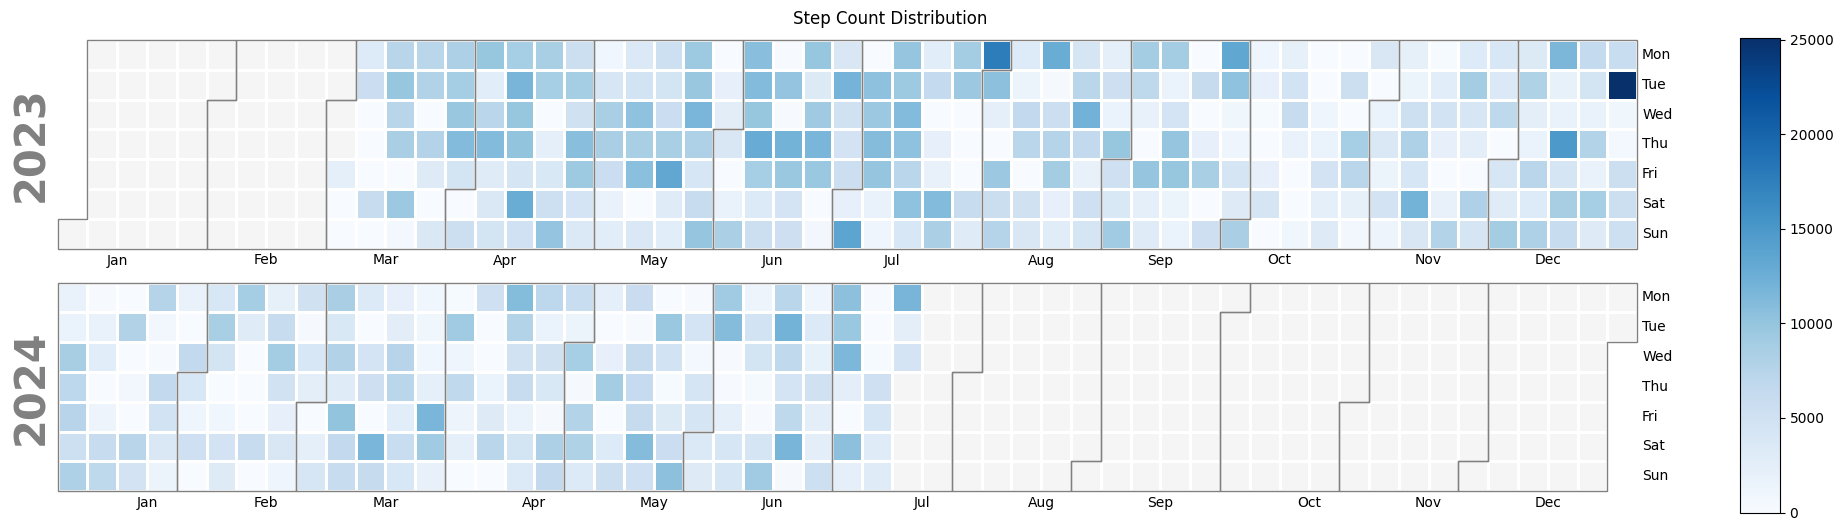

In [26]:
calplot.calplot(data['StepCount'], suptitle='Step Count Distribution', cmap='Blues', figsize=(20, 5))

### Total Energy Burned Distribution

(<Figure size 2000x500 with 3 Axes>,
 array([<Axes: ylabel='2023'>, <Axes: ylabel='2024'>], dtype=object))

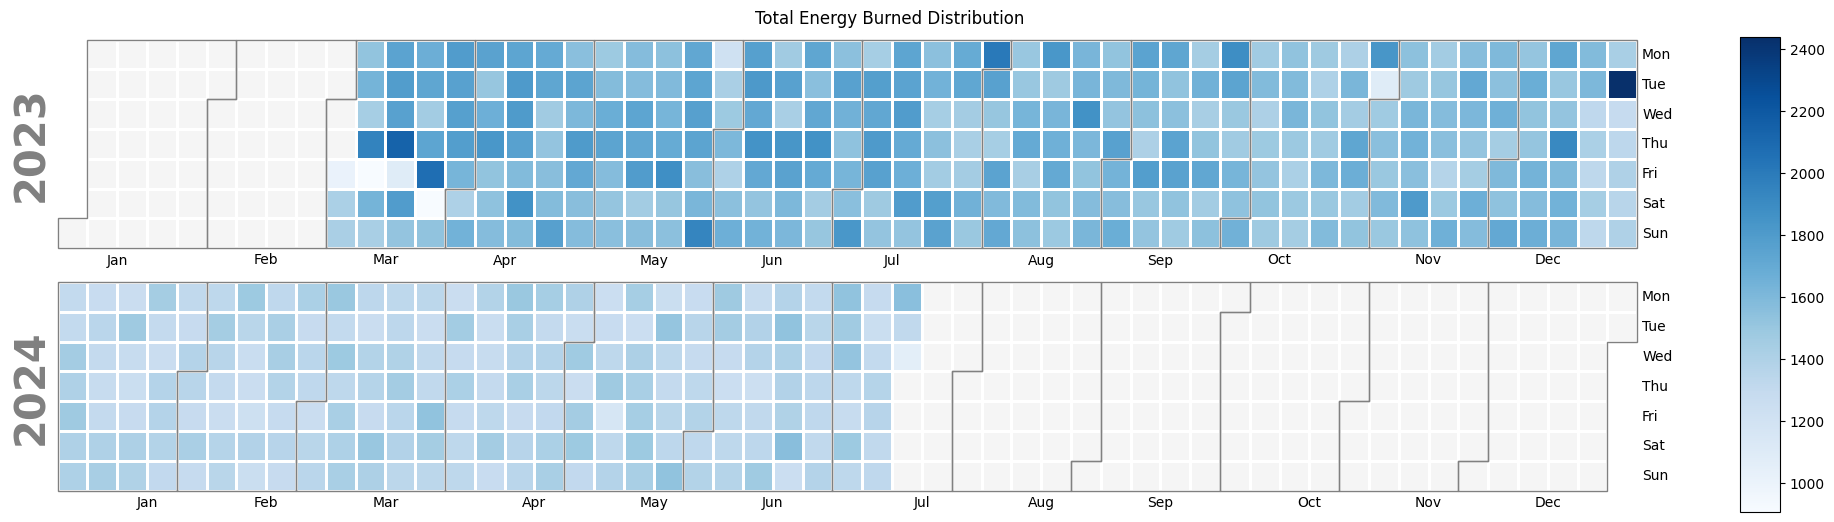

In [27]:
calplot.calplot(data['TotalEnergyBurned'], suptitle='Total Energy Burned Distribution', cmap='Blues', figsize=(20, 5))